<h2>Effect of Augmentation for downsized Cifar-10 when using resnet18 with no pretraining.</h2>
<h5>Problem Statement: Evaluate the effect of augmentatations(Mixup, Cutout, Standard) on performance of Resnet-18 model when trained with downisized(10k balanced all classes) dataset.</h5>
<h4>1. Reading the data from files<h4>

In [27]:
import numpy as np
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


# Integrating the batches and segregating according to the classes
base_addres = '/kaggle/input/cifar10/'
labels = list()
full_data = None
for batch in range(1,6):
    d = unpickle(base_addres + 'data_batch_' + str(batch))
    labels = labels + d[b'labels']
    if full_data is None:
        full_data = d[b'data']
    else:
        full_data = np.append(full_data, d[b'data'], axis=0)
full_data = full_data.reshape(full_data.shape[0], 3, 1024)
labels = np.array(labels)
labels = labels.reshape(-1,1)

<h4>2. Preparing and preprocessing the train and test data</h4>
<h5>2.1 Downsampling the train data</h5>
<h5>2.2 Regularizing the train data(zero mean per image and unit variance)</h5> 

In [28]:
# Selecting 1000 random examples of each class for training
short_data = None
short_data_labels = None
for i in range(10):
    indices = np.where(labels[:,0] == i)[0]
    class_data = full_data[indices]
    selection = np.random.randint(0, class_data.shape[0], 1000)
    if short_data is None:
        short_data = class_data[selection]
        short_data_labels = np.ones((selection.shape[0],1)) * i
    else:
        short_data = np.append(short_data, class_data[selection], axis=0)
        short_data_labels = np.append(
            short_data_labels, np.ones((selection.shape[0],1)) * i, axis=0)


shuffled_indices = np.arange(short_data.shape[0])
np.random.shuffle(shuffled_indices)
short_data = short_data[shuffled_indices]
short_data_labels = short_data_labels[shuffled_indices]


# Normalizing input images
short_data = short_data - np.mean(short_data, axis=2).reshape(-1,3,1)
short_data = short_data/np.std(short_data, axis=2).reshape(-1,3,1)
short_data = short_data.reshape(-1,3,32,32)

<h4>3. Preparing the test data and encoding train and test outputs into one hot labels</h4>

In [29]:
d = unpickle(base_addres + 'test_batch')
test_labels = d[b'labels']
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(-1,1)
test_data = d[b'data']
test_data = test_data.reshape(test_data.shape[0], 3, 1024)
test_data = test_data - np.mean(test_data, axis=2).reshape(-1,3,1)
test_data = test_data/np.std(test_data, axis=2).reshape(-1,3,1)
test_data = test_data.reshape(-1,3,32,32)

def convert_to_one_hot(labels):
    one_hot_labels = np.zeros((labels.shape[0], 10))
    one_hot_labels[np.arange(labels.shape[0]), labels.astype(int).reshape(-1,)] = 1
    return one_hot_labels
short_data_labels = convert_to_one_hot(short_data_labels)
test_labels = convert_to_one_hot(test_labels)

<h4>Accuracy function</h4>

In [30]:
def accuracy(prediction, target):
    max_idxs = np.argmax(prediction, axis=1)
    result = target[np.arange(max_idxs.shape[0]), max_idxs] == 1
    result = result.astype(np.int8)
    return int(np.sum(result))/ result.shape[0]

<h4>4. Implementation of experiments.</h4>
<h5>4.1 Preparing data for pytorch.</h5>
<h5>4.2 Loading resnet18 model from pytorch.</h5>
<h5>4.3 Training loop</h5>

In [31]:
import torch
import torchvision.models as models
device = 'cuda'
short_data = torch.tensor(short_data, device=device)
short_data_labels = torch.tensor(short_data_labels, device=device)

test_data = torch.tensor(test_data, device=device)
test_labels = torch.tensor(test_labels)

batch_size = 64

dataset_train = torch.utils.data.TensorDataset(short_data, short_data_labels)
sampler = torch.utils.data.RandomSampler(dataset_train, replacement=True, num_samples=batch_size)
batch_sampler = torch.utils.data.BatchSampler(sampler=sampler, batch_size=batch_size, drop_last=False)
dataloader = torch.utils.data.DataLoader(dataset_train, batch_sampler=batch_sampler)

def train_and_test(dataloader, augmentations=[], ITR = 160000):
    train_loss = []
    train_acc = []
    test_acc = []
# Loading the model and setting up its optimization.
    model = models.resnet18()
    model.to(device)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 10, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    for itr in range(ITR):
        for data in dataloader:
            inputs, labels = data

# Implmentation of Augmentation
            for augmentation in augmentations:
                if augmentation['name'] == 'mixup':
                    inputs = inputs.to('cpu').detach().numpy()
                    labels = labels.to('cpu').detach().numpy()
                    alpha = augmentation['alpha']
                    lmbda = np.random.beta(alpha, alpha, batch_size)
                    element1 = np.random.randint(0, batch_size-1, batch_size)
                    element2 = np.random.randint(0, batch_size-1, batch_size)
                    inputs = (lmbda.reshape(-1, 1, 1, 1) * inputs[element1]
                              + (1 - lmbda.reshape(-1, 1, 1, 1)) * inputs[element2])
                    labels = (lmbda.reshape(-1, 1) * labels[element1]
                              + (1 - lmbda.reshape(-1, 1)) * labels[element2])
                    inputs = torch.tensor(inputs, device=device)
                    labels = torch.tensor(labels, device=device)
                elif augmentation['name'] == 'cutout':
                    k = augmentation['k']
                    indices_to_be_altered = np.where(np.random. rand(batch_size) > 0.5)[0]
                    window_x = np.random.randint(0, 32, indices_to_be_altered.shape[0])
                    window_y = np.random.randint(0, 32, indices_to_be_altered.shape[0])
                    window_x_start = window_x - int(k/2)
                    window_x_start[np.where(window_x_start < 0)[0]] = 0

                    window_x_end = window_x + (int(k/2) + k%2)
                    window_x_end[np.where(window_x_end > 31)[0]] = 31

                    window_y_start = window_y - int(k/2)
                    window_y_start[np.where(window_y_start < 0)[0]] = 0

                    window_y_end = window_y + (int(k/2) + k%2)
                    window_y_end[np.where(window_y_end > 31)[0]] = 31
                    
                    altr_indx = 0
                    for i in indices_to_be_altered:
                        inputs[i, :, window_x_start[altr_indx]:window_x_end[altr_indx],
                                     window_y_start[altr_indx]:window_y_end[altr_indx]] = 0
                        altr_indx += 1

                elif augmentation['name'] == 'standard':
                    inputs = inputs.to('cpu').detach().numpy()
                    k = augmentation['k']
                    x_shift = np.random.randint(-k, k, batch_size)
                    y_shift = np.random.randint(-k, k, batch_size)
                    flip_sample = np.random.rand(batch_size)
                    for i in range(batch_size):
                        inputs[i] = np.roll(inputs[i], (x_shift[i], y_shift[i]), axis=(1, 2))
                        if x_shift[i] > 0:
                            if y_shift[i] > 0:
                                inputs[i, :, 0:x_shift[i], :] = 0
                                inputs[i, :, :, 0:y_shift[i]] = 0
                            elif y_shift[i] < 0:
                                inputs[i, :, 0:x_shift[i], :] = 0
                                inputs[i, :, :, y_shift[i]:32] = 0
                        elif x_shift[i] < 0:
                            if y_shift[i] > 0:
                                inputs[i, :, x_shift[i]:32, :] = 0
                                inputs[i, :, :, 0:y_shift[i]] = 0
                            elif y_shift[i] < 0:
                                inputs[i, :, x_shift[i]:32,:] = 0
                                inputs[i, :, :, y_shift[i]:32] = 0
                        if flip_sample[i] > 0.5:
                            inputs[i,0] = np.fliplr(inputs[i,0])
                            inputs[i,1] = np.fliplr(inputs[i,1])
                            inputs[i,2] = np.fliplr(inputs[i,2])
                    inputs = torch.tensor(inputs, device=device)

# Optimizer step
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.to(device).float())
# Collection of training loss, accuracy and test loss.
            if (itr+1)%(ITR/100) == 0:
                train_loss.append(float(loss))
                acc = accuracy(model(test_data.float()).to('cpu').detach().numpy(), test_labels.detach().numpy())
                test_acc.append(acc)
                acc = accuracy(model(short_data.float()).to('cpu').detach().numpy(),
                               short_data_labels.to('cpu').detach().numpy())
                train_acc.append(acc)
            loss.backward()
            optimizer.step()
    return train_loss, train_acc, test_acc

<h4>5. Invocation of experiments and reporting their final accuracy</h4>
<br></br>
Training by default happens for 1000 epochs as 100 epochs did not show the differences between different expereiments clearly.

In [32]:
print('\nRaw Data')
r_tr_loss, r_tr_acc, r_t_acc = train_and_test(dataloader)
print('Final Test Accuracy:', r_t_acc[-1])
print('\nMixup 0.2')
m_2_tr_loss, m_2_tr_acc, m_2_t_acc = train_and_test(dataloader, augmentations=[{'name':'mixup', 'alpha':0.2}])
print('Final Test Accuracy:', m_2_t_acc[-1])
print('\nMixup 0.4')
m_4_tr_loss, m_4_tr_acc, m_4_t_acc = train_and_test(dataloader, augmentations=[{'name':'mixup', 'alpha':0.4}])
print('Final Test Accuracy:', m_4_t_acc[-1])
print('\nCutout')
c_tr_loss, c_tr_acc, c_t_acc = train_and_test(dataloader, augmentations=[{'name':'cutout', 'k':16}])
print('Final Test Accuracy:', c_t_acc[-1])
print('\nStandard')
s_tr_loss, s_tr_acc, s_t_acc = train_and_test(dataloader, augmentations=[{'name':'standard', 'k':4}])
print('Final Test Accuracy:', s_t_acc[-1])


Raw Data
Final Test Accuracy: 0.6141

Mixup 0.2
Final Test Accuracy: 0.6578

Mixup 0.4
Final Test Accuracy: 0.6583

Cutout
Final Test Accuracy: 0.6272

Standard
Final Test Accuracy: 0.7582


<h4>6. Plotting the graphs</h4>
<h5>Following graphs are plotted from left to right</h5>
<h5>6.1 Training loss on y-axis vs % of epochs on x-axis</h5>
<h5>6.2 Training accuracy on y-axis vs % of epochs on x-axis</h5>
<h5>6.3 Test accuracy on y-axis vs % of epochs on x-axis</h5> 

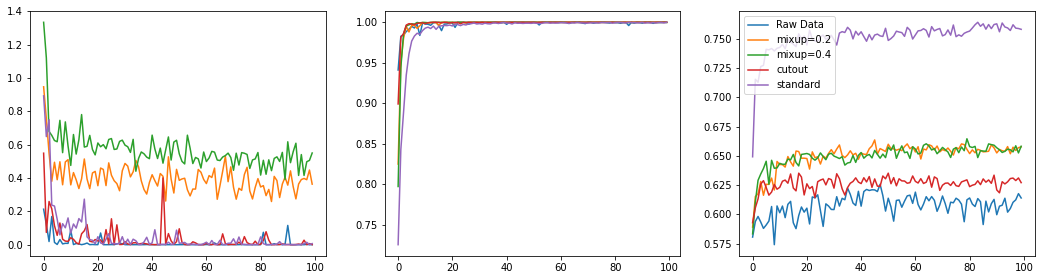

In [33]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18,4.5))
axs[0].plot(range(100), r_tr_loss, label='Raw Data')
axs[1].plot(range(100), r_tr_acc, label='Raw Data')
axs[2].plot(range(100), r_t_acc, label='Raw Data')

axs[0].plot(range(100), m_2_tr_loss, label='mixup=0.2')
axs[1].plot(range(100), m_2_tr_acc, label='mixup=0.2')
axs[2].plot(range(100), m_2_t_acc, label='mixup=0.2')

axs[0].plot(range(100), m_4_tr_loss, label='mixup=0.4')
axs[1].plot(range(100), m_4_tr_acc, label='mixup=0.4')
axs[2].plot(range(100), m_4_t_acc, label='mixup=0.4')

axs[0].plot(range(100), c_tr_loss, label='cutout')
axs[1].plot(range(100), c_tr_acc, label='cutout')
axs[2].plot(range(100), c_t_acc, label='cutout')

axs[0].plot(range(100), s_tr_loss, label='standard')
axs[1].plot(range(100), s_tr_acc, label='standard')
axs[2].plot(range(100), s_t_acc, label='standard')
plt.legend()

<h4>7. Combined Augmentation <h4>
<h5> As we can see for mixup, both 0.4 and 0.2 do not show a substantial difference in test accuracy performance. Hence, both of them are tested in combined augmentation.</h5> 
<h5>7.1 Combination of standard, cutout and mixup(alpha=0.4)</h5>
<h5>7.2 Combination of standard, cutout and mixup(alpha=0.2)</h5>

In [36]:
print('\nAll Combined')
a_tr_loss, a_tr_acc, a_t_acc = train_and_test(dataloader,
                                              augmentations=[{'name':'standard', 'k':4},
                                                             {'name':'cutout', 'k':16},
                                                             {'name':'mixup', 'alpha':0.4}])
print('Final Test Accuracy:', a_t_acc[-1])


All Combined
Final Test Accuracy: 0.789


In [38]:
print('\nAll Combined')
a_2_tr_loss, a_2_tr_acc, a_2_t_acc = train_and_test(dataloader,
                                              augmentations=[{'name':'standard', 'k':4},
                                                             {'name':'cutout', 'k':16},
                                                             {'name':'mixup', 'alpha':0.2}])
print('Final Test Accuracy:', a_2_t_acc[-1])


All Combined
Final Test Accuracy: 0.78


<h4>8. Plotting the performance of combined augmentation with other augmentations.<h4>
<h5>8.1 Training loss on y-axis vs % of epochs on x-axis</h5>
<h5>8.2 Training accuracy on y-axis vs % of epochs on x-axis</h5>
<h5>8.3 Test accuracy on y-axis vs % of epochs on x-axis</h5> 

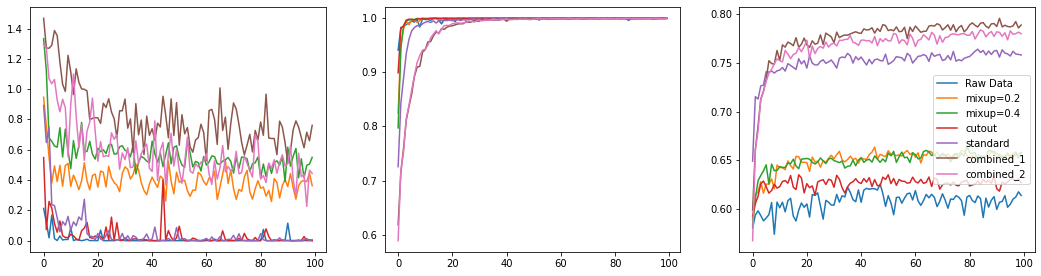

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(18,4.5))
axs[0].plot(range(100), r_tr_loss, label='Raw Data')
axs[1].plot(range(100), r_tr_acc, label='Raw Data')
axs[2].plot(range(100), r_t_acc, label='Raw Data')

axs[0].plot(range(100), m_2_tr_loss, label='mixup=0.2')
axs[1].plot(range(100), m_2_tr_acc, label='mixup=0.2')
axs[2].plot(range(100), m_2_t_acc, label='mixup=0.2')

axs[0].plot(range(100), m_4_tr_loss, label='mixup=0.4')
axs[1].plot(range(100), m_4_tr_acc, label='mixup=0.4')
axs[2].plot(range(100), m_4_t_acc, label='mixup=0.4')

axs[0].plot(range(100), c_tr_loss, label='cutout')
axs[1].plot(range(100), c_tr_acc, label='cutout')
axs[2].plot(range(100), c_t_acc, label='cutout')

axs[0].plot(range(100), s_tr_loss, label='standard')
axs[1].plot(range(100), s_tr_acc, label='standard')
axs[2].plot(range(100), s_t_acc, label='standard')

axs[0].plot(range(100), a_tr_loss, label='combined_1')
axs[1].plot(range(100), a_tr_acc, label='combined_1')
axs[2].plot(range(100), a_t_acc, label='combined_1')

axs[0].plot(range(100), a_2_tr_loss, label='combined_2')
axs[1].plot(range(100), a_2_tr_acc, label='combined_2')
axs[2].plot(range(100), a_2_t_acc, label='combined_2')
plt.legend()